# Multimodal Sentiment Model

In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

## Model Definition

In [14]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [88]:
class MultimodalSentimentModel(nn.Module):
    def __init__(self, audio_feature_dim, facial_feature_dim, text_feature_dim, encoding_dim, output_dim, dropout_rate=0):
        super(MultimodalSentimentModel, self).__init__()
        
        total_feature_dim = encoding_dim * 3

        self.fc = nn.Linear(encoding_dim, output_dim)

        self.face_autoencoder = Autoencoder(input_dim=facial_feature_dim, encoding_dim=encoding_dim)
        self.text_autoencoder = Autoencoder(input_dim=text_feature_dim, encoding_dim=encoding_dim)
        self.audio_autoencoder = Autoencoder(input_dim=audio_feature_dim, encoding_dim=encoding_dim)
        self.concat_autoencoder = Autoencoder(input_dim=total_feature_dim, encoding_dim=encoding_dim)
        
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, audio_features, facial_features, text_features):
        text_encoded, _ = self.text_autoencoder(text_features)
        face_encoded, _ = self.face_autoencoder(facial_features)
        audio_encoded, _ = self.audio_autoencoder(audio_features)
        combined_features = torch.cat((audio_encoded, face_encoded, text_encoded), dim=1)
        concat_features, _ = self.concat_autoencoder(combined_features)
        x = F.relu(self.fc(concat_features))
        x = self.dropout(x)

        
        return x

## Dataset Definition

In [16]:
class MultimodalDataset(Dataset):
    def __init__(self, h5_file, split='train'):
        self.h5_file_path = h5_file
        self.split = split
        self.groups = []
        self.file = None
        self.open_file()
        
        if self.file is not None:
            self.collect_groups()

    def open_file(self):
        try:
            self.file = h5py.File(self.h5_file_path, 'r')
        except Exception as e:
            print(f"Failed to open file {self.h5_file_path}: {e}")

    def collect_groups(self):
        for group_name in self.file:
            if self.file[group_name].attrs['split'] == self.split:
                self.groups.append(group_name)
                
    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        if self.file is None:
            print("HDF5 file is not opened.")
            return None
        
        try:
            group = self.file[self.groups[idx]]
            
            audio_features = torch.tensor(group['audio_features_averaged'][:], dtype=torch.float32)
            facial_features = torch.tensor(group['averaged_facial_features'][:], dtype=torch.float32)
            text_features = torch.tensor(group['bert_text_features_512'][:], dtype=torch.float32)
            
            label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
            label = torch.tensor(label_mapping[group.attrs['label']], dtype=torch.long)

            return audio_features, facial_features, text_features, label
        except Exception as e:
            print(f"Error loading data point {idx}: {e}")
            return None

    def __del__(self):
        if self.file is not None:
            self.file.close()
            print("HDF5 file closed.")
    

def create_dataloaders(h5_file, batch_size=64):
    train_dataset = MultimodalDataset(h5_file, 'train')
    validate_dataset = MultimodalDataset(h5_file, 'validate')
    test_dataset = MultimodalDataset(h5_file, 'test')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, validate_loader, test_loader

def print_loader_sizes(train_loader, validate_loader, test_loader):
    num_train_batches = len(train_loader)
    num_validate_batches = len(validate_loader)
    num_test_batches = len(test_loader)

    print(f"Total number of batches in Train Loader: {num_train_batches}")
    print(f"Total number of batches in Validate Loader: {num_validate_batches}")
    print(f"Total number of batches in Test Loader: {num_test_batches}")

    first_batch_train = next(iter(train_loader))
    print(f"Shapes of the first train batch - Audio Features: {first_batch_train[0].shape}, Facial Features: {first_batch_train[1].shape}, Text Features: {first_batch_train[2].shape}, Labels: {first_batch_train[3].shape}")

    first_batch_validate = next(iter(validate_loader))
    print(f"Shapes of the first validate batch - Audio Features: {first_batch_validate[0].shape}, Facial Features: {first_batch_validate[1].shape}, Text Features: {first_batch_validate[2].shape}, Labels: {first_batch_validate[3].shape}")

    first_batch_test = next(iter(test_loader))
    print(f"Shapes of the first test batch - Audio Features: {first_batch_test[0].shape}, Facial Features: {first_batch_test[1].shape}, Text Features: {first_batch_test[2].shape}, Labels: {first_batch_test[3].shape}")


## Training functions

In [17]:
def save_checkpoint(model, optimizer, epoch, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filepath)

def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch


In [18]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for audio_features, facial_features, text_features, labels in tqdm(dataloader):
        audio_features = audio_features.to(device)
        facial_features = facial_features.to(device)
        text_features = text_features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(audio_features, facial_features, text_features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for audio_features, facial_features, text_features, labels in tqdm(dataloader):
            audio_features = audio_features.to(device)
            facial_features = facial_features.to(device)
            text_features = text_features.to(device)
            labels = labels.to(device)

            outputs = model(audio_features, facial_features, text_features)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

def train_and_validate(model, optimizer,train_loader, validate_loader, num_epochs, device, learning_rate):
    loss_fn = nn.CrossEntropyLoss()

    training_losses = []
    validation_losses = []
    last_epoch_with_lower_val_loss = 0  # Track the last epoch where validation loss < training loss

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, validate_loader, loss_fn, device)
        training_losses.append(train_loss)
        validation_losses.append(val_loss)

        if val_loss == min(validation_losses):
            last_epoch_with_lower_val_loss = epoch  
            save_checkpoint(model, optimizer, epoch, f'mmsa_best.pth')  

        print(f'Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
        
        
        save_checkpoint(model, optimizer, epoch, f'mmsa_{epoch}.pth')

    return training_losses, validation_losses, last_epoch_with_lower_val_loss

def plot_losses(training_losses, validation_losses):
    epochs = range(1, len(training_losses) + 1)  
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.xticks(epochs)  
    plt.legend()
    plt.show()

def test(model, test_loader, device, epoch):

    test_loss, test_accuracy = validate(model, test_loader, nn.CrossEntropyLoss(), device)
    print(f'Epoch {epoch} Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

## Execution

In [102]:
# Hyperparams
batch_size = 64
num_epochs = 20
audio_feature_dim = 45 
facial_feature_dim = 2048 
text_feature_dim = 768 
encoding_dim = 512

learning_rate = 1e-5
dropout_rate = 0.1

# Other definitions
h5_file = r'combined_features.h5'
output_dim = 3  

HDF5 file closed.
HDF5 file closed.
HDF5 file closed.


100%|██████████| 22/22 [00:00<00:00, 52.75it/s]


Epoch 1, Train Loss: 1.0955027321637687, Train Accuracy: 0.34846201577874303, Val Loss: 1.0896616198799827, Val Accuracy: 0.37776193870277974


100%|██████████| 22/22 [00:00<00:00, 55.97it/s]


Epoch 2, Train Loss: 1.0753529058337885, Train Accuracy: 0.371686907189079, Val Loss: 1.0506774620576338, Val Accuracy: 0.44119743406985035


100%|██████████| 22/22 [00:00<00:00, 54.05it/s]


Epoch 3, Train Loss: 1.0350571864068845, Train Accuracy: 0.4107791862423544, Val Loss: 1.004375617612492, Val Accuracy: 0.47255880256593014


100%|██████████| 22/22 [00:00<00:00, 54.09it/s]


Epoch 4, Train Loss: 1.0076825076577354, Train Accuracy: 0.4323198298023225, Val Loss: 0.9861192405223846, Val Accuracy: 0.48253741981468284


100%|██████████| 22/22 [00:00<00:00, 54.99it/s]


Epoch 5, Train Loss: 0.9900781761454998, Train Accuracy: 0.4414502260437904, Val Loss: 0.9646934758533131, Val Accuracy: 0.488952245188881


100%|██████████| 22/22 [00:00<00:00, 56.47it/s]


Epoch 6, Train Loss: 0.977947817347144, Train Accuracy: 0.44685754808970835, Val Loss: 0.9499779451977123, Val Accuracy: 0.49679258731290094


100%|██████████| 22/22 [00:00<00:00, 51.64it/s]


Epoch 7, Train Loss: 0.970319351234005, Train Accuracy: 0.4499601099193334, Val Loss: 0.9465655467726968, Val Accuracy: 0.49394155381325733


100%|██████████| 22/22 [00:00<00:00, 54.99it/s]


Epoch 8, Train Loss: 0.9681281208318505, Train Accuracy: 0.44783263895044767, Val Loss: 0.9402530924840407, Val Accuracy: 0.49679258731290094


100%|██████████| 22/22 [00:00<00:00, 54.06it/s]


Epoch 9, Train Loss: 0.965032220897028, Train Accuracy: 0.4476553497030405, Val Loss: 0.9452968564900485, Val Accuracy: 0.49679258731290094


100%|██████████| 22/22 [00:00<00:00, 65.66it/s]


Epoch 10, Train Loss: 0.959241235323545, Train Accuracy: 0.45013739916674056, Val Loss: 0.9344721301035448, Val Accuracy: 0.5003563791874555


100%|██████████| 22/22 [00:00<00:00, 58.18it/s]


Epoch 11, Train Loss: 0.9601720150581188, Train Accuracy: 0.45332860562006916, Val Loss: 0.9369804669510234, Val Accuracy: 0.4982181040627227


100%|██████████| 22/22 [00:00<00:00, 54.12it/s]


Epoch 12, Train Loss: 0.9465975485279061, Train Accuracy: 0.4548355642230299, Val Loss: 0.9263135845010931, Val Accuracy: 0.5067712045616536


100%|██████████| 22/22 [00:00<00:00, 55.69it/s]


Epoch 13, Train Loss: 0.9444638813956309, Train Accuracy: 0.453151316372662, Val Loss: 0.9228634807196531, Val Accuracy: 0.5081967213114754


100%|██████████| 22/22 [00:00<00:00, 54.38it/s]


Epoch 14, Train Loss: 0.9398079369701234, Train Accuracy: 0.4606861093874656, Val Loss: 0.9272334602746096, Val Accuracy: 0.49679258731290094


100%|██████████| 22/22 [00:00<00:00, 55.71it/s]


Epoch 15, Train Loss: 0.9339354580405068, Train Accuracy: 0.45873592766598703, Val Loss: 0.9213480326262388, Val Accuracy: 0.49750534568781185


100%|██████████| 22/22 [00:00<00:00, 55.00it/s]


Epoch 16, Train Loss: 0.925923890986685, Train Accuracy: 0.46272493573264784, Val Loss: 0.9198024868965149, Val Accuracy: 0.49964362081254454


100%|██████████| 22/22 [00:00<00:00, 54.32it/s]


Epoch 17, Train Loss: 0.9289967552416742, Train Accuracy: 0.4597996631504299, Val Loss: 0.9204041226343675, Val Accuracy: 0.4982181040627227


100%|██████████| 22/22 [00:00<00:00, 53.91it/s]


Epoch 18, Train Loss: 0.9175730357735844, Train Accuracy: 0.46600478680968, Val Loss: 0.9144090847535566, Val Accuracy: 0.5024946543121882


100%|██████████| 22/22 [00:00<00:00, 56.02it/s]


Epoch 19, Train Loss: 0.9168227338521494, Train Accuracy: 0.46378867121709066, Val Loss: 0.9241532195698131, Val Accuracy: 0.4953670705630791


100%|██████████| 22/22 [00:00<00:00, 54.44it/s]


Epoch 20, Train Loss: 0.9173960534192748, Train Accuracy: 0.4645864728304228, Val Loss: 0.9192094233903018, Val Accuracy: 0.5024946543121882


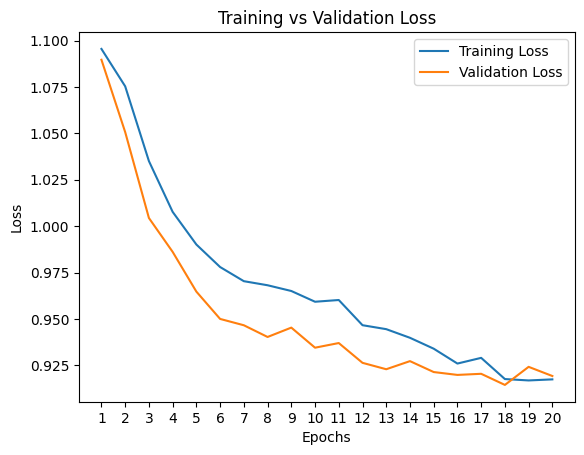

Testing the model from epoch 18


100%|██████████| 23/23 [00:00<00:00, 52.63it/s]

Epoch 18 Test Loss: 0.9113024369530056, Test Accuracy: 0.49014084507042255


In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalSentimentModel(
    audio_feature_dim=audio_feature_dim,
    facial_feature_dim=facial_feature_dim,
    text_feature_dim=text_feature_dim,
    encoding_dim=encoding_dim,
    output_dim=output_dim,
    dropout_rate=dropout_rate
).to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)

train_loader, validate_loader, test_loader = create_dataloaders(h5_file, batch_size)
# print_loader_sizes(train_loader, validate_loader, test_loader)

training_losses, validation_losses, last_epoch_with_lower_val_loss  = train_and_validate(model, optimizer, train_loader, validate_loader, num_epochs, device, learning_rate)
plot_losses(training_losses, validation_losses)

if last_epoch_with_lower_val_loss > 0:
    best_model_path = f'mmsa_best.pth'
    model, optimizer, _ = load_checkpoint(best_model_path, model, optimizer)
    print(f"Testing the model from epoch {last_epoch_with_lower_val_loss}")
    test(model, test_loader, device, last_epoch_with_lower_val_loss)
else:
    print("No epoch where the validation loss was lower than the training loss was found.")

## Ambitious Grid Search

In [ ]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def plot_losses(training_losses, validation_losses, test_accuracy, lr, hidden_size, second_hidden_size, save_path):
    epochs = range(1, len(training_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.title(f'Training vs Validation Loss\nlr={lr}, hidden_size={hidden_size}, second_hidden_size={second_hidden_size}\nTest Accuracy: {test_accuracy:.4f}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(epochs)
    plt.savefig(save_path)
    plt.close()

def train_and_validate(model, optimizer, train_loader, validate_loader, num_epochs, device, model_dir):
    loss_fn = nn.CrossEntropyLoss()

    training_losses = []
    validation_losses = []
    last_epoch_with_lower_val_loss = 0  # Track the last epoch where validation loss < training loss

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, validate_loader, loss_fn, device)
        training_losses.append(train_loss)
        validation_losses.append(val_loss)

        if val_loss < train_loss:
            last_epoch_with_lower_val_loss = epoch  
            best_checkpoint_path = os.path.join(model_dir, f"best_model.pth")
            save_checkpoint(model, optimizer, epoch, best_checkpoint_path) 

        print(f'Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
        
        # Save the model checkpoint for every epoch as well
        checkpoint_path = os.path.join(model_dir, f"model_epoch{epoch}.pth")
        save_checkpoint(model, optimizer, epoch, checkpoint_path)

    return training_losses, validation_losses, last_epoch_with_lower_val_loss


def test(model, test_loader, device, epoch):
    test_loss, test_accuracy = validate(model, test_loader, nn.CrossEntropyLoss(), device)
    print(f'Epoch {epoch} Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy

def grid_search(train_loader, validate_loader, test_loader, device, param_grid, num_epochs):
    results = []
    best_test_accuracy = -1 
    best_params = {} 
    base_model_dir = "models"
    ensure_dir(base_model_dir) 

    for lr in param_grid['learning_rate']:
        for hidden_size in param_grid['hidden_layer_size']:
            for second_hidden_size in param_grid['second_hidden_layer_size']:
                model_dir = f"{base_model_dir}/lr{lr}_hs{hidden_size}_shs{second_hidden_size}"
                ensure_dir(model_dir) 
                
                print(f"\nTraining with lr={lr}, hidden_layer_size={hidden_size}, second_hidden_layer_size={second_hidden_size}")
                model = MultimodalSentimentModel(
                    audio_feature_dim=45,
                    facial_feature_dim=2048,
                    text_feature_dim=768,
                    output_dim=3,
                    hidden_layer_size=hidden_size,
                    second_hidden_layer_size=second_hidden_size,
                    dropout_rate=0.1
                ).to(device)
                
                optimizer = Adam(model.parameters(), lr=lr)
                
                training_losses, validation_losses, last_epoch_with_lower_val_loss = train_and_validate(
                    model, optimizer, train_loader, validate_loader, num_epochs, device, model_dir)

                test_accuracy = None
                if last_epoch_with_lower_val_loss > 0:
                    best_model_path = f"{model_dir}/best_model.pth"
                    model, optimizer, _ = load_checkpoint(best_model_path, model, optimizer)
                    _, test_accuracy = test(model, test_loader, device, last_epoch_with_lower_val_loss)
                    if test_accuracy > best_test_accuracy:
                        best_test_accuracy = test_accuracy
                        best_params = {
                            'learning_rate': lr,
                            'hidden_layer_size': hidden_size,
                            'second_hidden_layer_size': second_hidden_size,
                            'last_epoch_with_lower_val_loss': last_epoch_with_lower_val_loss,
                            'test_accuracy': test_accuracy
                        }

                plot_save_path = f"plots/loss_plot_lr{lr}_hs{hidden_size}_shs{second_hidden_size}.png"
                plot_losses(training_losses, validation_losses, test_accuracy, lr, hidden_size, second_hidden_size, plot_save_path)

                results.append({
                    'learning_rate': lr,
                    'hidden_layer_size': hidden_size,
                    'second_hidden_layer_size': second_hidden_size,
                    'last_epoch_with_lower_val_loss': last_epoch_with_lower_val_loss,
                    'test_accuracy': test_accuracy
                })

    print("\nGrid Search Summary:")
    for result in results:
        print(result)

    return results, test_accuracy, best_params



In [ ]:
# param_grid = {
#     'learning_rate': [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],  
#     'hidden_layer_size': [2048, 1024, 512, 256, 128, 64, 32],  
#     'second_hidden_layer_size': [2048, 1024, 512, 256, 128, 64, 32]  
# }


# results = grid_search(train_loader, validate_loader, test_loader, device, param_grid, num_epochs=20)


In [11]:
results[2]

NameError: name 'results' is not defined